In [2]:
from osgeo import gdal,osr
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm

In [3]:
path = 'D:\\3_DataViz\\2_glaciers\\3_ncdf\\'
ncdf_src = 'GLIDATASET_ALPS.nc'

ds = gdal.Open(path+ncdf_src)

for item in ds.GetSubDatasets():
    print (item[0])

HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://errthickness
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://slope
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://stdx
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://stdy
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://thickness
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://vx
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://vy


In [11]:
# Option 1
#thickness = gdal.Open('NETCDF:"/Users/kdruken/Downloads/LS8_OLI_TIRS_NBAR_3577_-10_-28_2013.nc":band_2')

# Option 2
thickness = gdal.Open(ds.GetSubDatasets()[4][0])

print (thickness.GetMetadata())
print(type(thickness))

# Note GetRasterBand() takes band no. starting from 1 not 0
band = thickness.GetRasterBand(1)
arr = band.ReadAsArray()
arr = np.where(arr == 9.96921e+36,0,arr)


{'Author': 'R. Millan, J. Mouginot, A. Rabatel, M. Morlighem', 'Conventions': 'CF-1.6', 'history': 'Created Tue Apr 20 16:57:31 2021', 'Notes': 'Data were processed at the Institut des Geosciences de l Environnement, Grenoble, France', 'nx': '', 'ny': '', 'proj4': '+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs', 'Projection': 'UTM', 'Title': 'GLacier Ice dynamics DATASET  for ALPS', 'Version': '1.0.0 (August2019)', '_NCProperties': 'version=2,netcdf=4.7.4,hdf5=1.10.6'}
<class 'osgeo.gdal.Dataset'>


In [6]:
 (arr.min(), arr.max(), arr.mean(), arr.std())
#np.sum(np.array(arr) <= 0)

(-14.6640625, 689.0, 0.64137906, 9.850223)

In [7]:
print(arr.shape)
print(np.max(arr))
print(np.min(arr))

(6182, 11722)
689.0
-14.6640625


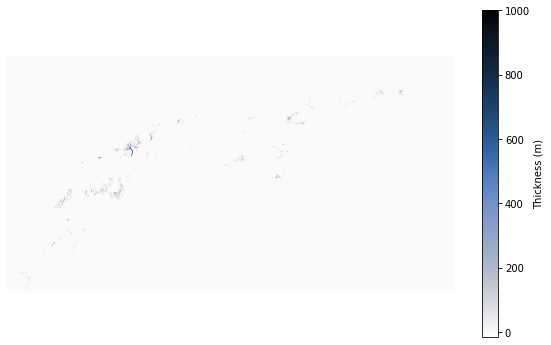

In [8]:
plt.figure(figsize=(10,12))
fig = plt.imshow(arr, origin='lower',vmax = 1000, cmap=cm.oslo_r)
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#tickval = [1, 10, 100, 100, 500]
#t = np.log(tickval)
cb = plt.colorbar(fig, shrink=0.5)
cb.set_label('Thickness (m)')
#cb.ax.set_yticklabels(tickval)
plt.show()

In [8]:
# apply the colormap to dataset
cmap=cm.oslo
rgb_ds = cmap(arr)
# rescale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
print(data_array_scaled.shape)

(6182, 11722, 4)


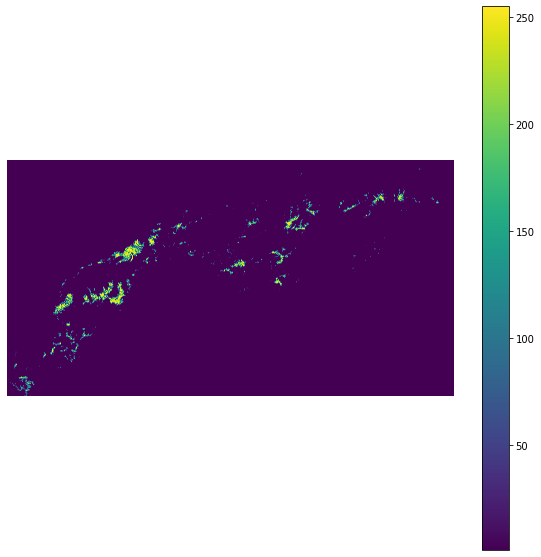

In [20]:
plt.figure(figsize=(10,10))
fig = plt.imshow(data_array_scaled[:,:,0], origin='lower')
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
cb = plt.colorbar(fig)
plt.show()

In [10]:
geotransform = thickness.GetGeoTransform ()
print(geotransform[0])
print(geotransform[3])
print(geotransform[1])
print(geotransform[5])
print(data_array_scaled.shape[2]-1)
print(thickness.RasterXSize)
print(thickness.RasterYSize)

0.0
0.0
1.0
1.0
3
11722
6182


In [22]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
out_path = 'D:\\3_DataViz\\2_glaciers\\3_ncdf\\geotiff\\'
dest_name = out_path + 'glidataset_alps_thickness.tif'

# info from source
geotransform = thickness.GetGeoTransform ()
originX = geotransform[0]
originY = geotransform[3]
pixelWidth = geotransform[1]
pixelHeight = geotransform[5]
bands = data_array_scaled.shape[2]-1
rows = thickness.RasterXSize
cols = thickness.RasterYSize

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2','GDAL_TIFF_INTERNAL_MASK=YES']

# Create new raster
dest = driver.Create(dest_name,rows,cols, bands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
dest.GetRasterBand(1).WriteArray(np.around(data_array_scaled[:,:,0]))
dest.GetRasterBand(1).SetNoDataValue(0)
dest.GetRasterBand(2).WriteArray(np.around(data_array_scaled[:,:,1]))
dest.GetRasterBand(2).SetNoDataValue(0)
dest.GetRasterBand(3).WriteArray(np.around(data_array_scaled[:,:,2]))
dest.GetRasterBand(3).SetNoDataValue(0)
# loop through bands and write new values
#or bix in range(3):
#    destb = dest.GetRasterBand(bix+1)
#    #Write array
#    destb.WriteArray(rgb_data[:,:,bix])

destSRS = osr.SpatialReference()
destSRS.ImportFromEPSG(3857)
dest.SetProjection(destSRS.ExportToWkt())

# Close datasets
#src = None
dest = None
rb = None
